In [42]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
pd.set_option('display.max_columns', None)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


In [22]:
data = pd.read_pickle('https://surfdrive.surf.nl/files/index.php/s/JdRmiW1qDh9ZJKV/download')

In [24]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f'The mae of the model is {mae}.')
    print(f'The mse of the model is {mse}.')
    print(f'The rmse of the model is {rmse}.')
    print(f'The r2 of the model is {r2}.')
    
    return rmse

In [25]:
# 86/14 split

In [26]:
test = data[data['year'] == 2019]
train = data[data['year']<2019]

In [27]:
lab = LabelEncoder()

labels_lsoa = data['LSOA name'].unique()
lab.fit(labels_lsoa)
train[['LSOA name']] = train[['LSOA name']].apply(lab.transform)
test[['LSOA name']] = test[['LSOA name']].apply(lab.transform)

C:\Users\20203203\.conda\envs\py39\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [28]:
labels_dist = data['name'].unique()
lab.fit(labels_dist)
train[['name']] = train[['name']].apply(lab.transform)
test[['name']] = test[['name']].apply(lab.transform)

In [29]:
labels_force = data['Force Name'].unique()
lab.fit(labels_force)
train[['Force Name']] = train[['Force Name']].apply(lab.transform)
test[['Force Name']] = test[['Force Name']].apply(lab.transform)

In [30]:
test.shape[0]/train.shape[0]

0.13945309714156623

# XGboost

In [31]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [33]:
X_train_xg = train[['LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_month_crimes']]
y_train_xg = train['amount_of_crimes']

X_test_xg = test[['LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_month_crimes']]
y_test_xg = test['amount_of_crimes']

X_train_xg2 = train[['LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_year_crimes']]
y_train_xg2 = train['amount_of_crimes']

X_test_xg2 = test[['LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_year_crimes']]
y_test_xg2 = test['amount_of_crimes']

X_train_xg3 = train[['LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year']]
y_train_xg3 = train['amount_of_crimes']

X_test_xg3 = test[['LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year']]
y_test_xg3 = test['amount_of_crimes']


In [34]:
#XGboost 2

def xg_model(X_train, y_train, X_test, y_test):
    #global variables
    
    global pred
    
    # Creating matrices optimal for xgboost
    
    train_dmatrix = xg.DMatrix(data = X_train, label = y_train)
    test_dmatrix = xg.DMatrix(data = X_test, label = y_test)

    # Parameter dictionary specifying base learner and model training
    
    param = {"booster":"gbtree", "objective":"reg:squarederror"}
    xgb = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 20)
    pred = xgb.predict(test_dmatrix)
    
    # Model for feature importance evaluation
    
    xgb_f = xg.XGBRegressor()
    xgb_f.fit(X_train, y_train)

    # Model evaluation
    
    mae = mean_absolute_error(y_test_xg, pred)
    mse = mean_squared_error(y_test_xg, pred)
    rmse = np.sqrt(mean_squared_error(y_test_xg, pred))
    r2 = r2_score(y_test_xg, pred)
    
    i = 0
    feature_imp = {}
    for f in X_train.columns:
        feature_imp[f] = xgb_f.feature_importances_[i]
        i += 1
    #feature_imp = xgb_f.feature_importances_
    
    print(f'The mae of the model is {mae}.')
    print(f'The mse of the model is {mse}.')
    print(f'The rmse of the model is {rmse}.')
    print(f'The r2 of the model is {r2}.')
    print(f'The feature importance of the model is {feature_imp}.')

In [35]:
xg_model(X_train_xg2, y_train_xg2, X_test_xg2, y_test_xg2)

The mae of the model is 5.12351159738751.
The mse of the model is 79.68950964693033.
The rmse of the model is 8.926898097711788.
The r2 of the model is 0.8615654057203462.
The feature importance of the model is {'LSOA population_last_year': 0.01378178, 'population_last_year': 0.013275042, 'LSOA name': 0.0075136297, 'IMD score': 0.025532467, 'GDP_last_year': 0.015432542, 'prev_year_crimes': 0.9244645}.


In [36]:
xg_model(X_train_xg3, y_train_xg3, X_test_xg3, y_test_xg3)

The mae of the model is 7.911122364320147.
The mse of the model is 297.7527911294656.
The rmse of the model is 17.255514803374183.
The r2 of the model is 0.4827514058215838.
The feature importance of the model is {'LSOA population_last_year': 0.14098935, 'population_last_year': 0.08682904, 'LSOA name': 0.27414182, 'IMD score': 0.35829806, 'GDP_last_year': 0.13974182}.


In [37]:
xg_model(X_train_xg, y_train_xg, X_test_xg, y_test_xg)

The mae of the model is 4.712666969516731.
The mse of the model is 53.18029493365559.
The rmse of the model is 7.292482083190578.
The r2 of the model is 0.9076165409295309.
The feature importance of the model is {'LSOA population_last_year': 0.00665932, 'population_last_year': 0.0062876013, 'LSOA name': 0.0050858576, 'IMD score': 0.01723956, 'GDP_last_year': 0.008273695, 'prev_month_crimes': 0.956454}.


# Visualizations

Text(27.0, 0.5, 'Predicted amount of crimes')

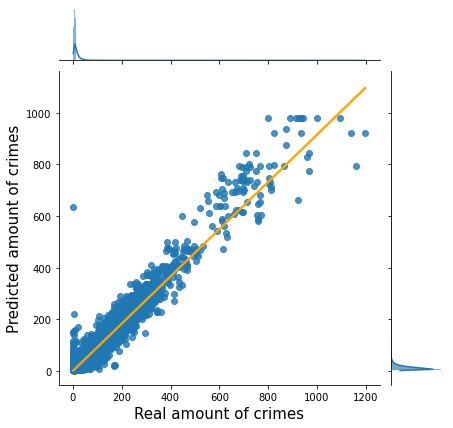

In [40]:
# Regressors
ax = sns.jointplot(x=y_test_xg, y=pred, kind='reg', line_kws={"color": "orange"})
ax.ax_joint.set_xlabel('Real amount of crimes', size=15)
ax.ax_joint.set_ylabel('Predicted amount of crimes', size=15)

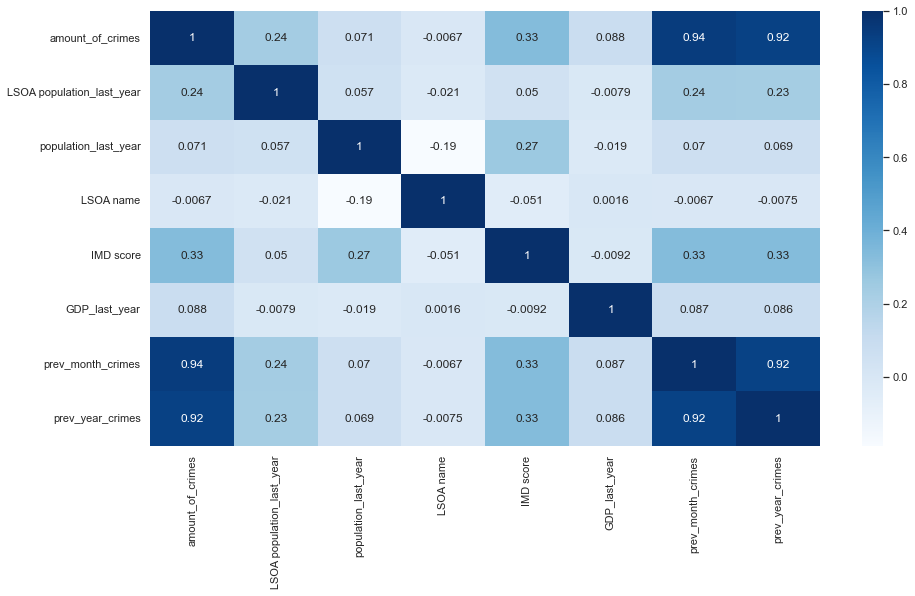

In [43]:
# Feature correlation

sns.heatmap(train[['amount_of_crimes', 'LSOA population_last_year', 'population_last_year', 'LSOA name', 'IMD score', 'GDP_last_year', 'prev_month_crimes', 'prev_year_crimes']].corr(), cmap='Blues', annot=True)
sns.set(rc = {'figure.figsize':(15,8)})
plt.show()

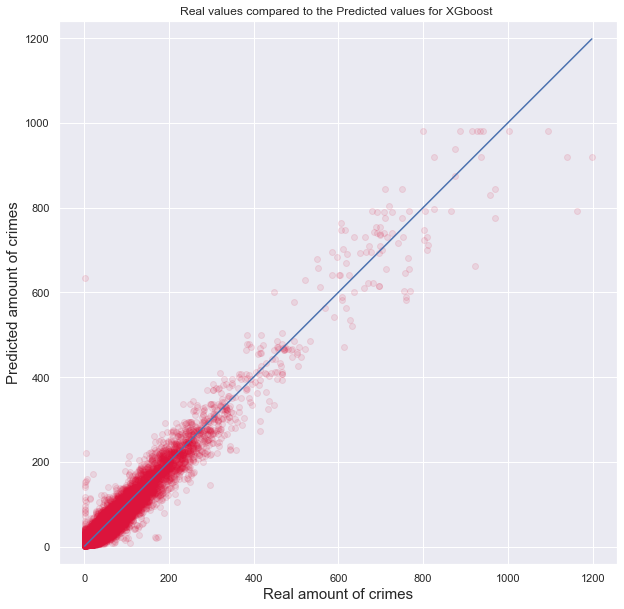

In [44]:


plt.figure(figsize=(10,10))
plt.scatter(y_test_xg, pred, c='crimson', alpha = 0.1)

p1 = max(max(pred), max(y_test_xg))
p2 = min(min(pred), min(y_test_xg))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.title('Real values compared to the Predicted values for XGboost ')
plt.xlabel('Real amount of crimes', fontsize=15)
plt.ylabel('Predicted amount of crimes', fontsize=15)
plt.axis('equal');

In [45]:
test = data[data['year'] == 2019]
test_data_forecasted = test.copy()
test_data_forecasted['predicted_amount_of_crimes'] = pred
top_5_df = test_data_forecasted[['LSOA name', 'predicted_amount_of_crimes', 'LSOA population_last_year']]
top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_predicted = top_5_df.sort_values('predicted_amount_of_crimes_per_head', ascending=False).head(10).reset_index()


test_data_forecasted = test.copy()
top_5_df = test_data_forecasted[['LSOA name', 'amount_of_crimes', 'LSOA population_last_year']]
top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']
top_5_df = top_5_df.groupby('LSOA name').mean()
top_5_df_real = top_5_df.sort_values('amount_of_crimes_per_head', ascending=False).head(10).reset_index()

display(top_5_df_real[['LSOA name', 'amount_of_crimes','amount_of_crimes_per_head']], top_5_df_predicted[['LSOA name', 'predicted_amount_of_crimes','predicted_amount_of_crimes_per_head']])

C:\Users\20203203\AppData\Local\Temp/ipykernel_8684/578229939.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['predicted_amount_of_crimes_per_head'] = top_5_df['predicted_amount_of_crimes'] / top_5_df['LSOA population_last_year']
C:\Users\20203203\AppData\Local\Temp/ipykernel_8684/578229939.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_5_df['amount_of_crimes_per_head'] = top_5_df['amount_of_crimes'] / top_5_df['LSOA population_last_year']


,LSOA name,amount_of_crimes,amount_of_crimes_per_head
0,City of London 001F,720.750000,0.640667
1,Westminster 013E,897.166667,0.639008
2,Westminster 018A,874.750000,0.466533
3,Manchester 054C,575.333333,0.363905
4,Birmingham 138A,465.166667,0.332025
5,Westminster 018C,633.166667,0.321731
6,Westminster 013B,742.166667,0.267640
7,Westminster 018B,309.833333,0.232085
8,Gloucester 004F,234.916667,0.194307
9,Kingston upon Hull 029E,313.500000,0.193042


,LSOA name,predicted_amount_of_crimes,predicted_amount_of_crimes_per_head
0,Westminster 013E,906.047424,0.645333
1,City of London 001F,693.310791,0.616276
2,Westminster 018A,809.562866,0.431767
3,Manchester 054C,598.771667,0.378730
4,Birmingham 138A,453.727905,0.323860
5,Westminster 018C,624.980896,0.317572
6,Westminster 013B,751.047424,0.270843
7,Westminster 018B,296.796387,0.222319
8,Newcastle upon Tyne 024G,448.372284,0.195284
9,Gloucester 004F,228.361938,0.188885
